In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Planning:

- Working with Big 5 personality test data from Kaggle.
- Want to do a clustering project to see if I can find groupings of personality 'types' based on responses.
- Would like to see if I can create a mechanism that will allow someone to answer the questionaire and see what the model would predict their personality to be.

# Acquire:

In [2]:
#Importing Data From CSV (this file uses '\t' as the delimeter, so I need to account for that):
df = pd.read_csv('big_5_data.csv', sep = '\t')

In [3]:
df.head(1)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991


# Prepare:

In [4]:
#Creating list to drop columns that contain time to click answers, as well as screen size and latitude/longitude guesses:
drop_columns = ['EXT1_E', 'EXT2_E', 'EXT3_E', 'EXT4_E', 'EXT5_E', 'EXT6_E', 'EXT7_E', 'EXT8_E', 'EXT9_E', 'EXT10_E', 'EST1_E', 'EST2_E', 'EST3_E', 'EST4_E', 'EST5_E', 'EST6_E', 'EST7_E', 'EST8_E', 'EST9_E', 'EST10_E', 'AGR1_E', 'AGR2_E', 'AGR3_E', 'AGR4_E', 'AGR5_E', 'AGR6_E', 'AGR7_E', 'AGR8_E', 'AGR9_E', 'AGR10_E', 'CSN1_E', 'CSN2_E', 'CSN3_E', 'CSN4_E', 'CSN5_E', 'CSN6_E', 'CSN7_E', 'CSN8_E', 'CSN9_E', 'CSN10_E', 'OPN1_E', 'OPN2_E', 'OPN3_E', 'OPN4_E', 'OPN5_E', 'OPN6_E', 'OPN7_E', 'OPN8_E', 'OPN9_E', 'OPN10_E', 'screenw', 'screenh', 'lat_appx_lots_of_err', 'long_appx_lots_of_err', 'dateload', 'introelapse', 'testelapse', 'endelapse']

#Should I leave the elapsed time columns in, and just create a separate dataframe set for modeling?

In [5]:
#Dropping Unneeded Columns:
df = df.drop(columns=drop_columns)

In [6]:
#Converting all '0.0' values to null:
df = df.replace(0.0, np.nan)

In [7]:
#Determining the number of null values in the data:
#df.isnull().sum()

In [8]:
#It appears that there are, at most, 13,000 '0.0' or nulls in the data. 
#I'm going to go ahead and drop the rows containing null values:
df = df.dropna()

In [9]:
reverse_scored = ["EXT2","EXT4","EXT6","EXT8","EXT10","EST2","EST4","AGR1","AGR3","AGR5","AGR7","CSN2","CSN4","CSN6","CSN8","OPN2","OPN4","OPN6"]

In [10]:
# Dropping rows that come from non-unique IP addresses for the sake of cleanliness:
df = df.drop(df[df.IPC > 1].index)

In [11]:
#Dropping 'IPC' column after dropping non-unique IP rows:
df = df.drop(columns = 'IPC')

In [12]:
#Dropping the Country Columns:
#df = df.drop(columns = 'country')

In [13]:
# Splitting the data (this is the code from the curriculum - return to customize later):

# split test off, 20% of original df size. 
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)

print("train observations: ", train.shape[0])
print("validate observations: ", validate.shape[0])
print("test observations: ", test.shape[0])

train observations:  337827
validate observations:  144784
test observations:  120653


In [14]:
#Creating groups of questions based on metric they evaluate:

extroversion = {"EXT1" : "I am the life of the party.",
"EXT2" : "I don't talk a lot.",
"EXT3" : "I feel comfortable around people.",
"EXT4" : "I keep in the background.",
"EXT5" : "I start conversations.",
"EXT6" : "I have little to say.",
"EXT7" : "I talk to a lot of different people at parties.",
"EXT8" : "I don't like to draw attention to myself.",
"EXT9" : "I don't mind being the center of attention.",
"EXT10" : "I am quiet around strangers."}

neuroticism = {"EST1" : "I get stressed out easily.",
"EST2" : "I am relaxed most of the time.",
"EST3" : "I worry about things.",
"EST4" : "I seldom feel blue.",
"EST5" : "I am easily disturbed.",
"EST6" : "I get upset easily.",
"EST7" : "I change my mood a lot.",
"EST8" : "I have frequent mood swings.",
"EST9" : "I get irritated easily.",
"EST10" : "I often feel blue."}

agreeableness = {"AGR1" : "I feel little concern for others.",
"AGR2" : "I am interested in people.",
"AGR3" : "I insult people.",
"AGR4" : "I sympathize with others' feelings.",
"AGR5" : "I am not interested in other people's problems.",
"AGR6" : "I have a soft heart.",
"AGR7" : "I am not really interested in others.",
"AGR8" : "I take time out for others.",
"AGR9" : "I feel others' emotions.",
"AGR10" : "I make people feel at ease."}

conscientiousness = {"CSN1" : "I am always prepared.",
"CSN2" : "I leave my belongings around.",
"CSN3" : "I pay attention to details.",
"CSN4" : "I make a mess of things.",
"CSN5" : "I get chores done right away.",
"CSN6" : "I often forget to put things back in their proper place.",
"CSN7" : "I like order.",
"CSN8" : "I shirk my duties.",
"CSN9" : "I follow a schedule.",
"CSN10" : "I am exacting in my work."}

openness = {"OPN1" : "I have a rich vocabulary.",
"OPN2" : "I have difficulty understanding abstract ideas.",
"OPN3" : "I have a vivid imagination.",
"OPN4" : "I am not interested in abstract ideas.",
"OPN5" : "I have excellent ideas.",
"OPN6" : "I do not have a good imagination.",
"OPN7" : "I am quick to understand things.",
"OPN8" : "I use difficult words.",
"OPN9" : "I spend time reflecting on things.",
"OPN10" : "I am full of ideas."}

## Preparation Considerations:
- There are many cells that have 0.0 in their values. I will need to get rid of these, just like I got rid of the null values.
- It does not appear that it was considered, so I need to go through and fix the values in question that are reverse-scored.
- Do I need to keep the following:
    - introelapse The time in seconds spent on the landing / intro page
    - testelapse  The time in seconds spent on the page with the survey questions
    - endelapse   The time in seconds spent on the finalization page (where the user was asked to indicate if they has answered
    * The only real value of this would be to see if there is a relationship between time lapse and any of the big 5. Maybe higher elapsed times indicates more neuroticism (lower on 'emotional stability')?
    * I could also create a dataset for modeling that has these removed, but leave them in my original set for analysis, if needed.

# Exploration:

In [15]:
pal = sns.color_palette('colorblind')
pal.as_hex()

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [16]:
print(pal.as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


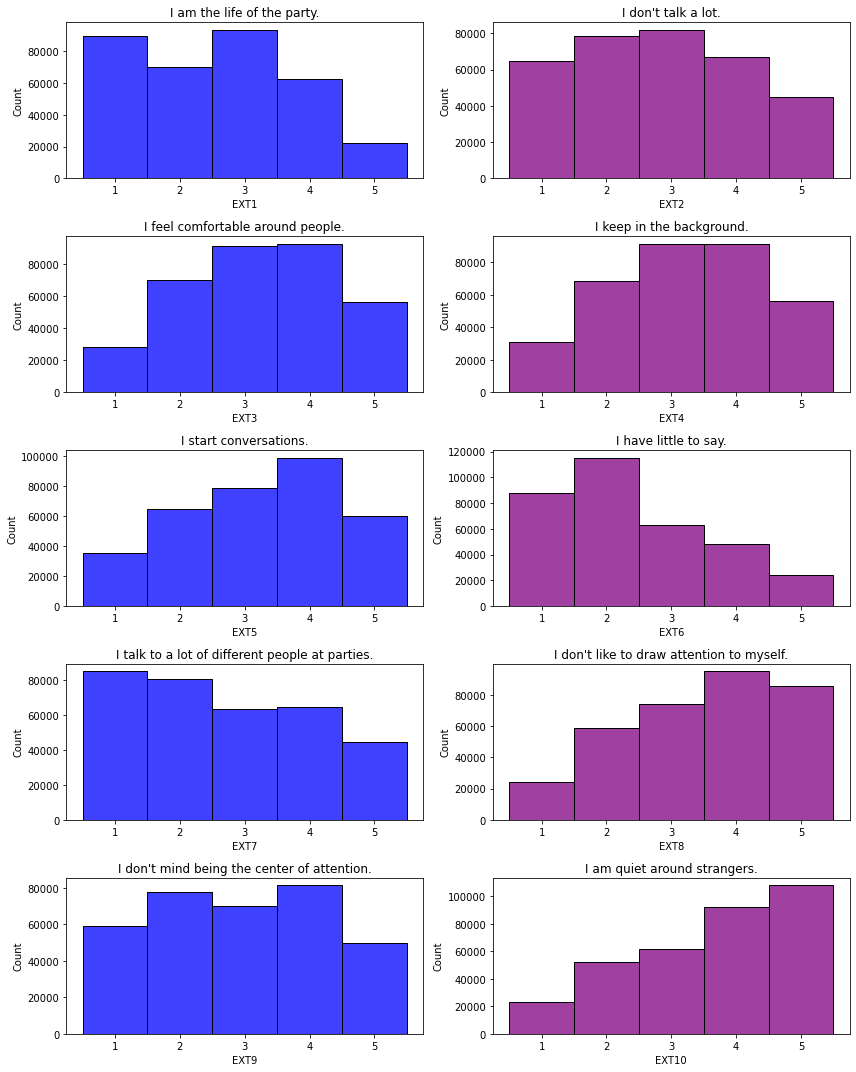

In [17]:
#fig = plt.subplots(ncols=5, nrows=2)
keys = list(extroversion.keys())
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    if i in reverse_scored:
        rs = 'purple'
    else:
        rs = 'blue'
    plt.subplot(5, 2, count + 1)
    sns.histplot(data = train[i].astype(int), bins=bins, color = rs).set(title = extroversion[i]);
plt.tight_layout();

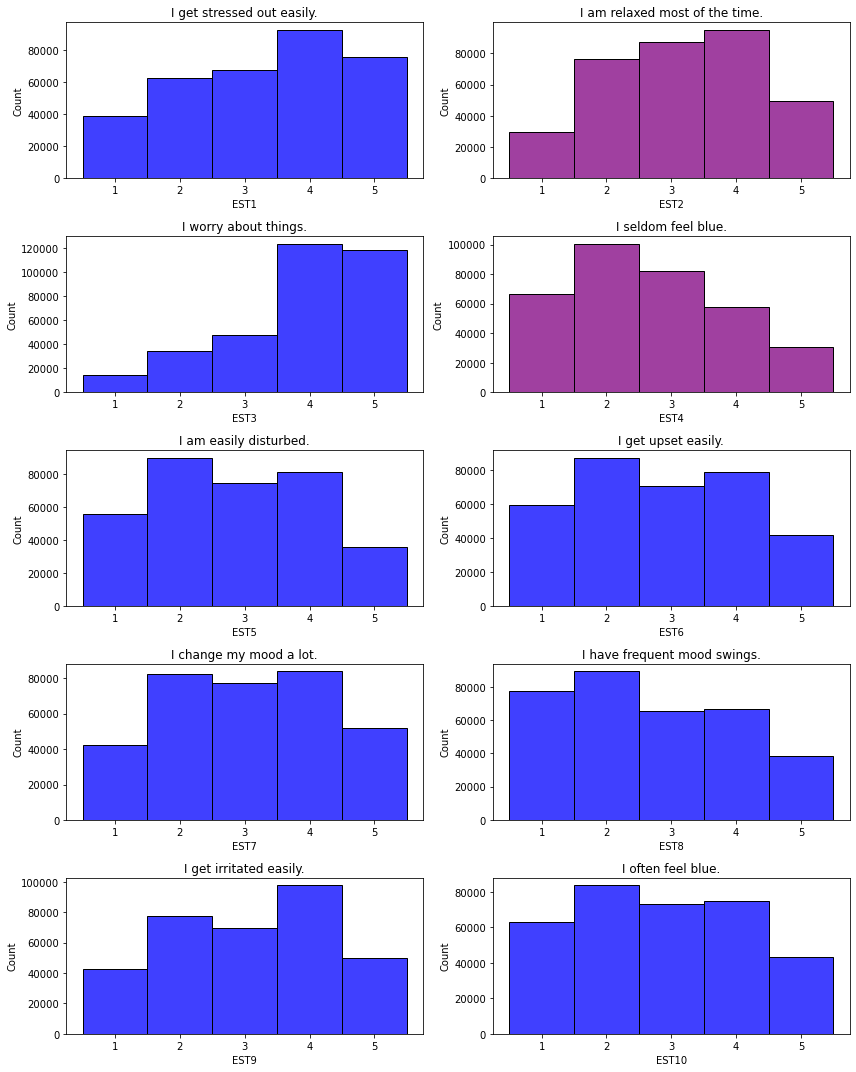

In [18]:
#fig = plt.subplots(ncols=5, nrows=2)
keys = list(neuroticism.keys())
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    if i in reverse_scored:
        rs = 'purple'
    else:
        rs = 'blue'
    plt.subplot(5, 2, count + 1)
    sns.histplot(data = train[i].astype(int), bins=bins, color = rs).set(title = neuroticism[i]);
plt.tight_layout()

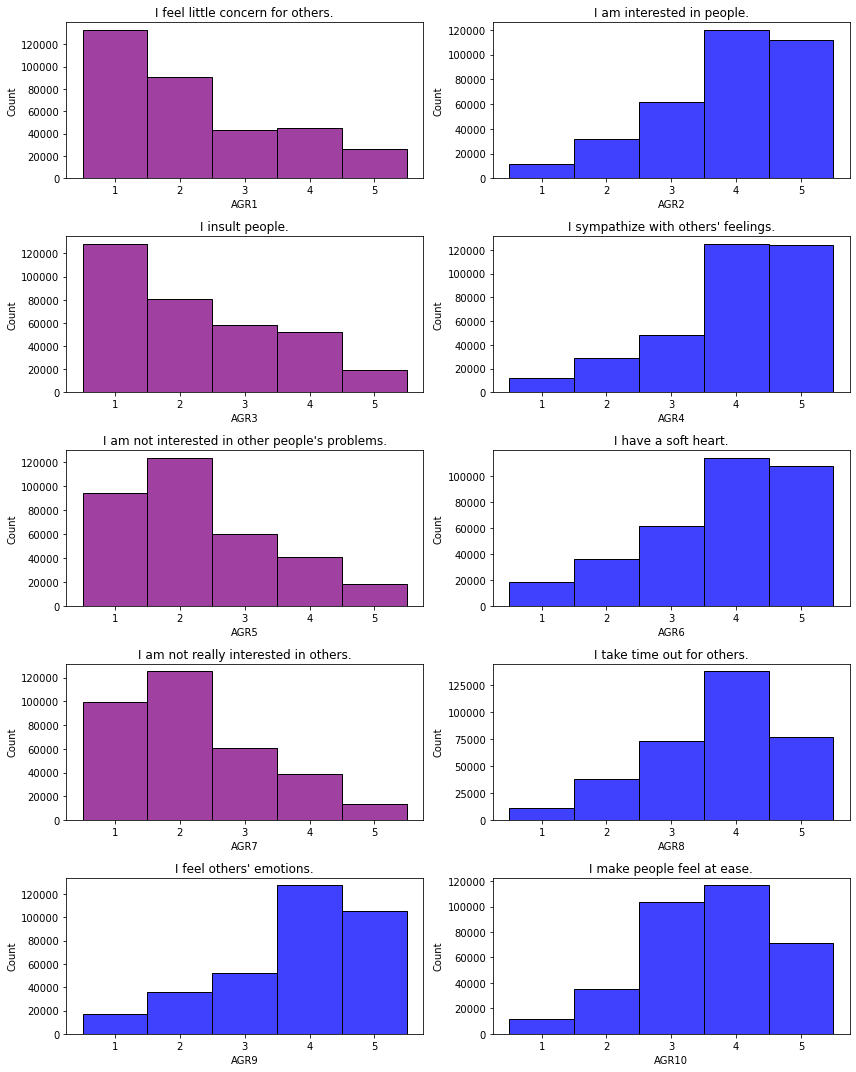

In [19]:
#fig = plt.subplots(ncols=5, nrows=2)
keys = list(agreeableness.keys())
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    if i in reverse_scored:
        rs = 'purple'
    else:
        rs = 'blue'
    plt.subplot(5, 2, count + 1)
    sns.histplot(data = train[i].astype(int), bins=bins, color = rs).set(title = agreeableness[i]);
plt.tight_layout()

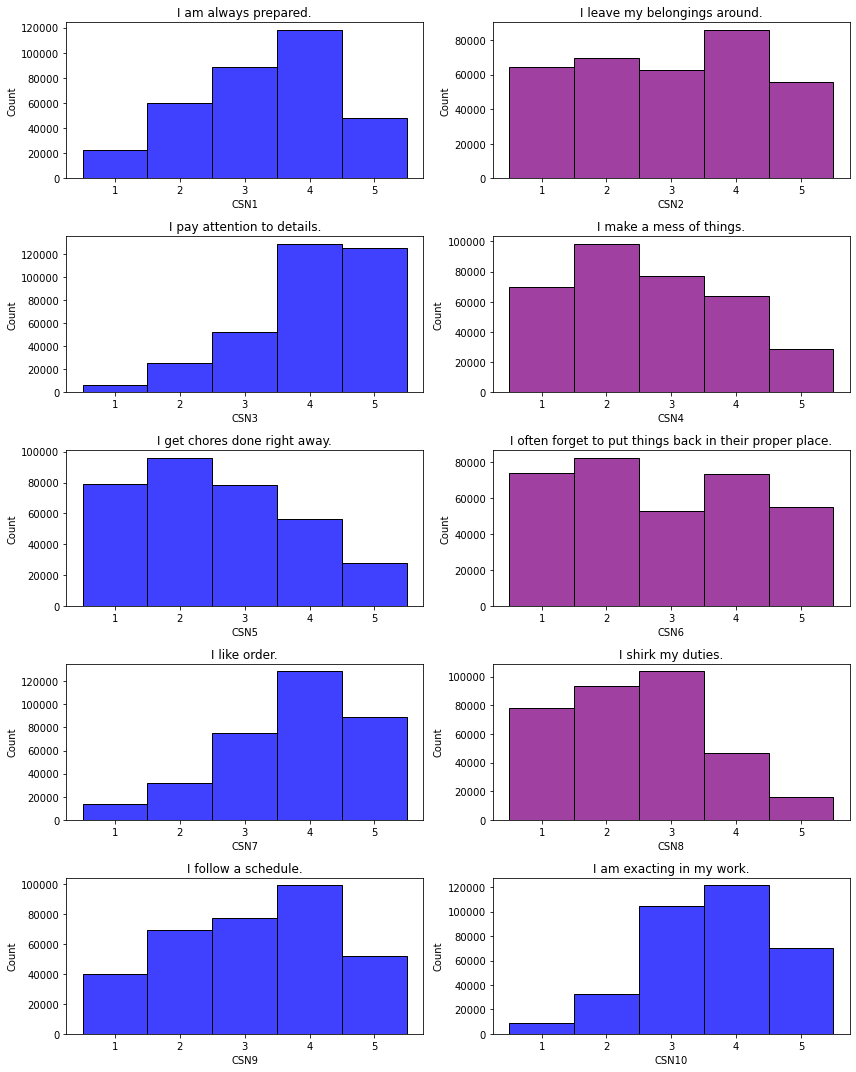

In [20]:
#fig = plt.subplots(ncols=5, nrows=2)
keys = list(conscientiousness.keys())
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    if i in reverse_scored:
        rs = 'purple'
    else:
        rs = 'blue'
    plt.subplot(5, 2, count + 1)
    sns.histplot(data = train[i].astype(int), bins=bins, color = rs).set(title = conscientiousness[i]);
plt.tight_layout()

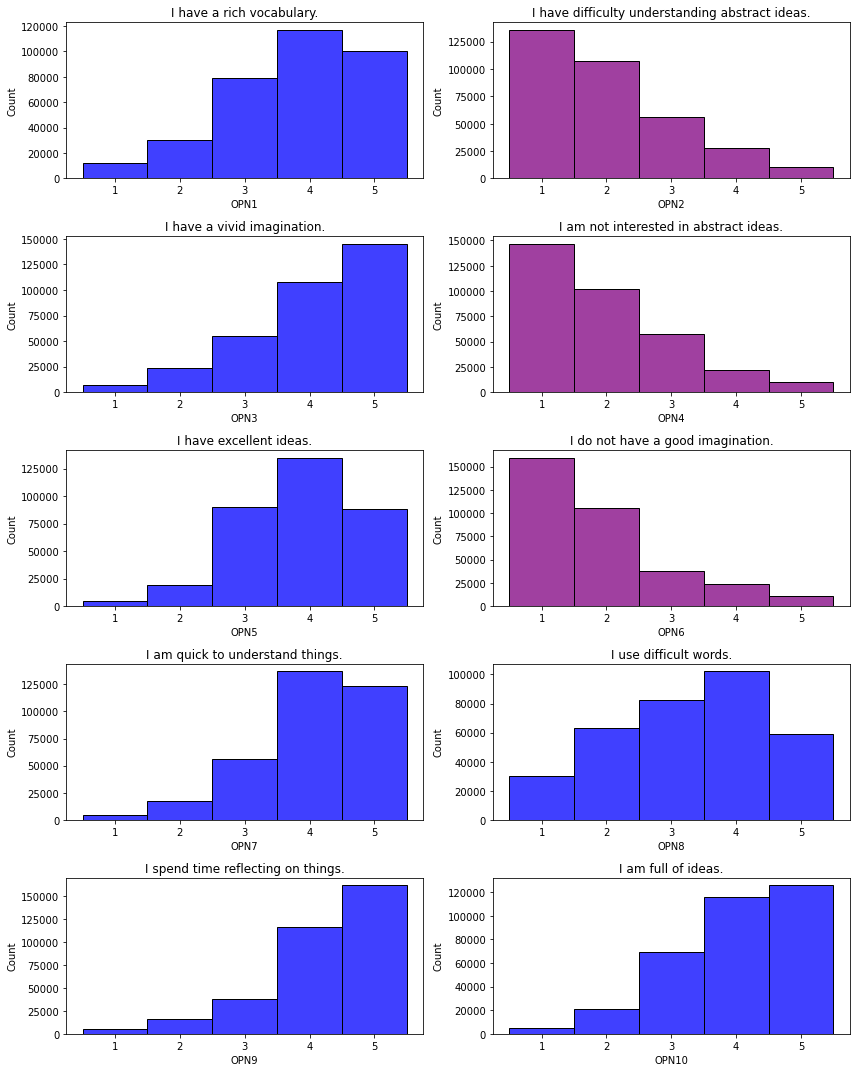

In [21]:
#fig = plt.subplots(ncols=5, nrows=2)
keys = list(openness.keys())
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    if i in reverse_scored:
        rs = 'purple'
    else:
        rs = 'blue'
    plt.subplot(5, 2, count + 1)
    sns.histplot(data = train[i].astype(int), bins=bins, color = rs).set(title = openness[i]);
plt.tight_layout()

In [22]:
def reverseScoring(df, high, cols):
    '''Reverse scores on given columns
     df = your data frame,
     high = highest score available
     cols = the columns you want reversed in list form'''
    df[cols] = (high + 1) - df[cols]
    return df

In [23]:
reverseScoring(df, 5, reverse_scored)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,...,5.0,4.0,5.0,4.0,5.0,5.0,3.0,4.0,5.0,GB
1,3.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,...,4.0,4.0,4.0,3.0,5.0,4.0,2.0,5.0,3.0,MY
2,2.0,3.0,4.0,2.0,3.0,4.0,1.0,3.0,2.0,1.0,...,5.0,2.0,5.0,4.0,4.0,5.0,3.0,4.0,4.0,GB
3,2.0,4.0,2.0,3.0,4.0,4.0,2.0,2.0,1.0,2.0,...,4.0,5.0,4.0,3.0,5.0,4.0,4.0,3.0,3.0,GB
5,3.0,3.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,2.0,...,5.0,5.0,5.0,3.0,5.0,5.0,4.0,5.0,2.0,SE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015334,4.0,5.0,4.0,4.0,4.0,3.0,3.0,4.0,3.0,4.0,...,3.0,5.0,3.0,4.0,4.0,5.0,2.0,3.0,4.0,GB
1015335,5.0,5.0,5.0,4.0,4.0,4.0,3.0,5.0,5.0,5.0,...,5.0,4.0,4.0,3.0,4.0,5.0,3.0,4.0,4.0,TR
1015337,4.0,3.0,4.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,...,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,US
1015339,2.0,2.0,3.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,...,4.0,4.0,4.0,3.0,4.0,4.0,5.0,5.0,3.0,US


In [24]:
#Graphing Mean Score of Each Category:

mean_extroversion = 0
for i in extroversion.keys():
    mean_extroversion += train[i].mean()
    
mean_neuroticism = 0
for i in neuroticism.keys():
    mean_neuroticism += train[i].mean()
    
mean_agreeableness = 0
for i in agreeableness.keys():
    mean_agreeableness += train[i].mean()
    
mean_conscientiousness = 0
for i in conscientiousness.keys():
    mean_conscientiousness += train[i].mean()
    
mean_openness = 0
for i in openness.keys():
    mean_openness += train[i].mean()

In [25]:
metric_names = ['extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
metric_means = [mean_extroversion, mean_neuroticism, mean_agreeableness, mean_conscientiousness, mean_openness]
metric_means_df = pd.DataFrame()
metric_means_df['metric_names'] = pd.DataFrame(metric_names)
metric_means_df['means'] = metric_means

In [26]:
metric_means_df

,metric_names,means
0,extroversion,30.302744
1,neuroticism,30.464522
2,agreeableness,31.678507
3,conscientiousness,31.429901
4,openness,33.091097


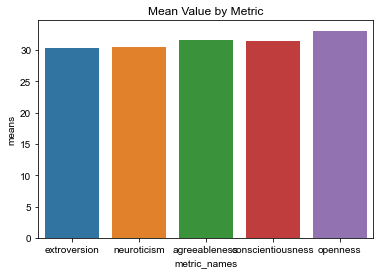

In [27]:
sns.barplot(data = metric_means_df, x = metric_means_df['metric_names'], y = metric_means_df['means']).set(title = 'Mean Value by Metric')
sns.set(rc = {'figure.figsize':(15,8)});

<AxesSubplot:>

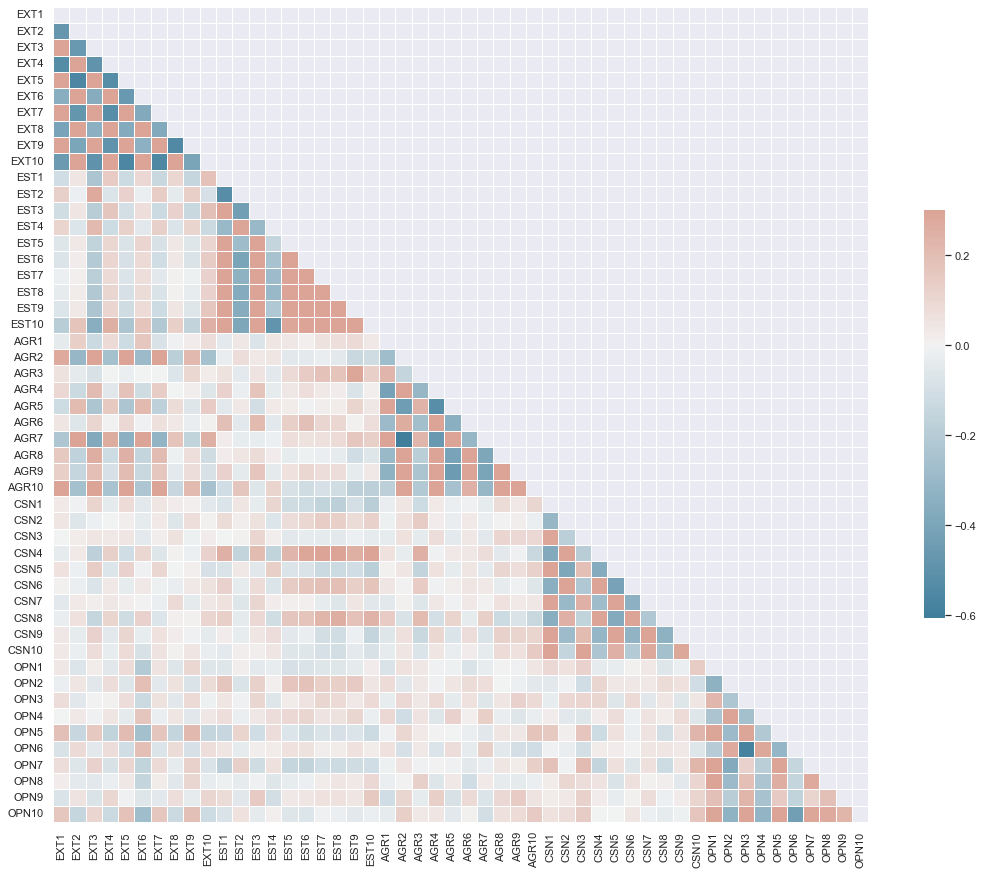

In [28]:
corr = train.corr()
f, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Pre-Processing for Modeling:

In [29]:
#I'm just going to remove the 'country' column from the dataset befor doing modeling:
def pre_process(train = train, validate = validate, test = test):
    '''
    Takes in train, validate, and test dataframes, returns version of each with
    the 'country' column removed, as that column may be used for analysis, but will
    not be included in the modeling process. Returns train_model, validate_model, 
    and test_model.
    '''
    for i in [train, validate, test]:
        train_model = train.drop(columns = 'country')
        validate_model = validate.drop(columns = 'country')
        test_model = test.drop(columns = 'country')
    return train_model, validate_model, test_model

In [30]:
train_model, validate_model, test_model = pre_process()

# Modeling:

## Figuring out ideal hyperparameters for model:

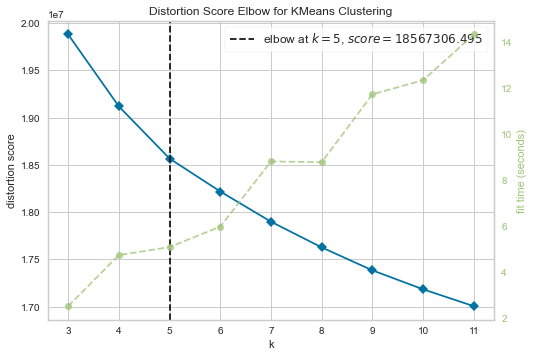

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(3,12), timings= True)
visualizer.fit(train_model)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

## Creating and Running the Model:

In [32]:
#Creating the model object and fitting it to the data:
kmeans = KMeans(n_clusters=5)
kmeans.fit(train_model)

#Generating predictions with fitted model:
cluster = kmeans.predict(train_model)

In [33]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(train_model)

train_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
train_pca['cluster'] = kmeans.predict(train_model)
train_pca.head()

,PCA1,PCA2,cluster
0,-2.349532,5.750227,1
1,0.582173,1.171218,2
2,-2.144435,-0.206403,4
3,3.444983,-0.241034,3
4,-3.458839,-1.478864,4


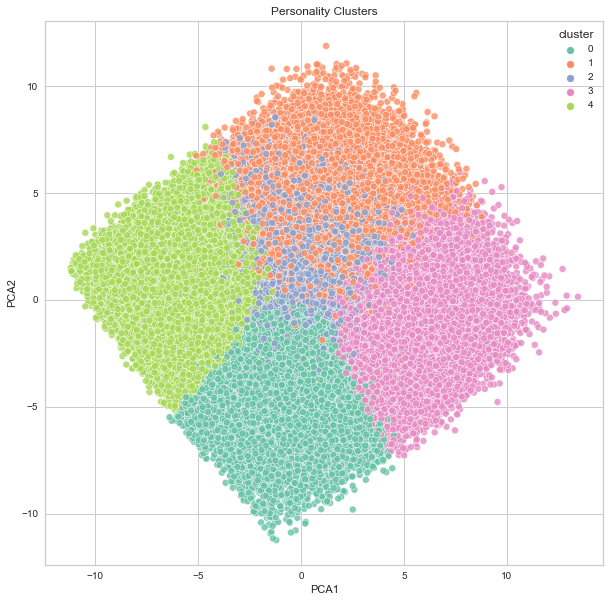

In [34]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=train_pca, x='PCA1', y='PCA2', hue='cluster', palette='Set2', alpha=0.8)
plt.title('Personality Clusters');